In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
daataframe_aisles = pd.read_csv('aisles.csv')
daataframe_departments = pd.read_csv('departments.csv')
daataframe_order_products_prior = pd.read_csv('orderproductsprior.csv')
daataframe_order_products_train = pd.read_csv('orderproductstrain.csv')
daataframe_orders = pd.read_csv('orders.csv')
daataframe_products = pd.read_csv('products.csv')

In [4]:
daataframe_order_products_prior.shape

(32434489, 4)

In [6]:
daataframe_order_products_train.shape

(1384617, 4)

In [8]:
daataframe_orders.shape

(3421083, 7)

In [9]:
def Get_Subset_Data(dataframe, test_size=.1, seed=24):

    rs = np.random.RandomState(seed)
    
    total_users = dataframe['user_id'].unique() 
    Tst_Urs = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)


    dataframe_subset = dataframe[dataframe['user_id'].isin(Tst_Urs)]  
    
    return dataframe_subset

In [12]:
daataframe_orders = Get_Subset_Data(daataframe_orders)

In [14]:
daataframe_order_products_prior = daataframe_order_products_prior.merge(daataframe_orders.drop('eval_set', axis = 1), on = 'order_id')
daataframe_order_products_train = daataframe_order_products_train.merge(daataframe_orders.drop('eval_set', axis = 1), on = 'order_id')

In [15]:
daataframe_order_products_prior.shape

(3216994, 9)

In [16]:
daataframe_order_products_train.shape

(140747, 9)

In [17]:
daataframe_orders.shape

(340378, 7)

In [19]:
daataframe_user_product = (daataframe_order_products_prior.groupby(['product_id','user_id'],as_index=False) 
                                          .agg({'order_id':'count'}) 
                                          .rename(columns={'order_id':'user_product_total_orders'}))

Training_IDs = daataframe_order_products_train['user_id'].unique() 
daataframe_X = daataframe_user_product[daataframe_user_product['user_id'].isin(Training_IDs)]
daataframe_X.head(10)

,product_id,user_id,user_product_total_orders
0,1,1494,3
1,1,3010,1
5,1,10315,1
6,1,11119,1
7,1,12892,1
8,1,18586,2
10,1,20687,1
11,1,21219,1
13,1,24324,6
14,1,30618,3


In [20]:
Training_Carts = (daataframe_order_products_train.groupby('user_id',as_index=False)
                                      .agg({'product_id':(lambda x: set(x))})
                                      .rename(columns={'product_id':'latest_cart'}))

In [21]:
Training_Carts.head(10)

,user_id,latest_cart
0,59,"{22912, 34949, 2825, 47888, 21137, 19611, 4440..."
1,103,{13225}
2,109,"{35042, 30406, 47144, 6473, 5450, 26477, 21936..."
3,163,"{22721, 16610, 26981, 12391, 14036, 36214, 423..."
4,164,"{34905, 10212, 2086, 39721, 4942, 21903, 35121..."
5,171,"{24129, 47107, 34534, 41319, 29640, 9225, 6793..."
6,201,"{43129, 329, 9337}"
7,235,"{22400, 14048, 37158, 9383, 25513, 45066, 4852..."
8,283,"{32971, 32303, 41973, 43352, 41596, 16797}"
9,289,"{47042, 47209, 30442, 6187, 35503, 21137, 2203..."


In [22]:
daataframe_X = daataframe_X.merge(Training_Carts, on='user_id')
daataframe_X['in_cart'] = (daataframe_X.apply(lambda row: row['product_id'] in row['latest_cart'], axis=1).astype(int))

daataframe_X.head(10)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart
0,1,1494,3,{44560},0
1,130,1494,2,{44560},0
2,397,1494,1,{44560},0
3,881,1494,1,{44560},0
4,1004,1494,2,{44560},0
5,1648,1494,2,{44560},0
6,2449,1494,1,{44560},0
7,2745,1494,2,{44560},0
8,3126,1494,2,{44560},0
9,4377,1494,3,{44560},0


In [23]:
Target_Packets = daataframe_X.in_cart.value_counts(normalize=True) 
print(Target_Packets)

0    0.901262
1    0.098738
Name: in_cart, dtype: float64


In [24]:
daataframe_X.head(10)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart
0,1,1494,3,{44560},0
1,130,1494,2,{44560},0
2,397,1494,1,{44560},0
3,881,1494,1,{44560},0
4,1004,1494,2,{44560},0
5,1648,1494,2,{44560},0
6,2449,1494,1,{44560},0
7,2745,1494,2,{44560},0
8,3126,1494,2,{44560},0
9,4377,1494,3,{44560},0


In [25]:
def Plot_Features(dataframe, sample_size=500):
    
    sample = (daataframe.drop(['product_id','user_id','latest_cart'],axis=1)
                .sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='in_cart', plot_kws=dict(alpha=.3, edgecolor='none'))

In [26]:
def GetUserSplitData(daataframe, test_size=.2, seed=42):

    random_state = np.random.RandomState(seed)
    
    All_Users = daataframe['user_id'].unique() 
    Tst_Urs = random_state.choice(All_Users, 
                           size=int(All_Users.shape[0] * test_size), 
                           replace=False)

    daataframe_Train = daataframe[~daataframe['user_id'].isin(Tst_Urs)] 
    Test_daataframe = daataframe[daataframe['user_id'].isin(Tst_Urs)]  
   
    y_Train, y_Test = daataframe_Train['in_cart'], Test_daataframe['in_cart'] 
    X_Train = daataframe_Train.drop(['product_id','user_id','latest_cart','in_cart'],axis=1) 
    X_Test = Test_daataframe.drop(['product_id','user_id','latest_cart','in_cart'],axis=1) 
    
    return X_Train, X_Test, y_Train, y_Test

In [27]:
X_Train, X_Test, y_Train, y_Test = GetUserSplitData(daataframe_X)

In [28]:
logistic_regression_grocery = LogisticRegression(solver='lbfgs')
logistic_regression_grocery.fit(X_Train, y_Train)
f1_score(logistic_regression_grocery.predict(X_Test), y_Test)

0.08444659048232202

In [29]:
logistic_regression_grocery.coef_

array([[0.14635276]])

In [31]:
Features_Products = ['product_total_orders','product_avg_add_to_cart_order']
daataframe_Features_Products = (daataframe_order_products_prior.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('add_to_cart_order','mean')])))
daataframe_Features_Products.columns = ['product_id'] + Features_Products
daataframe_Features_Products.head(10)

,product_id,product_total_orders,product_avg_add_to_cart_order
0,1,195,5.579487
1,2,6,6.333333
2,3,12,4.833333
3,4,31,8.516129
4,6,1,26.000000
5,7,1,2.000000
6,8,3,13.333333
7,9,17,5.705882
8,10,190,8.710526
9,11,4,6.000000


In [33]:
daataframe_X = daataframe_X.merge(daataframe_Features_Products, on='product_id')
daataframe_X.head(10)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order
0,1,1494,3,{44560},0,195,5.579487
1,1,3010,1,"{26088, 20940, 26348, 32689, 6008, 13176}",0,195,5.579487
2,1,10315,1,{21386},0,195,5.579487
3,1,11119,1,"{17122, 8803, 43352, 41400, 5769, 14477, 21903...",0,195,5.579487
4,1,12892,1,"{43136, 5161, 17720}",0,195,5.579487
5,1,18586,2,"{196, 9477, 37710}",0,195,5.579487
6,1,20687,1,{8958},0,195,5.579487
7,1,21219,1,"{653, 39190, 29463, 46107, 10662, 17191, 33959...",0,195,5.579487
8,1,24324,6,"{43459, 40709, 36551, 25513, 45321, 37178, 441...",0,195,5.579487
9,1,30618,3,"{37317, 46058, 22507, 8079, 12341, 4920, 28413...",0,195,5.579487


In [34]:
X_Train, X_Test, y_Train, y_Test = GetUserSplitData(daataframe_X)

logistic_regression_grocery = LogisticRegression()
logistic_regression_grocery.fit(X_Train, y_Train)
f1_score(logistic_regression_grocery.predict(X_Test), y_Test)

0.09867132496956223

In [35]:
Features_Users = ['user_total_orders','user_avg_cartsize','user_total_products','user_avg_days_since_prior_order']

daataframe_Features_Users = (daataframe_order_products_prior.groupby(['user_id'],as_index=False)
                                           .agg(OrderedDict(    
                                                   [('order_id',['nunique', (lambda x: x.shape[0] / x.nunique())]),
                                                    ('product_id','nunique'),
                                                    ('days_since_prior_order','mean')])))

daataframe_Features_Users.columns = ['user_id'] + Features_Users
daataframe_Features_Users.head(10)

,user_id,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order
0,4,5,3.600000,17,15.357143
1,20,4,5.500000,7,5.500000
2,22,15,4.600000,34,11.952381
3,25,3,7.000000,19,30.000000
4,59,10,9.200000,60,18.126582
5,77,12,16.916667,128,12.300000
6,100,5,5.400000,20,26.320000
7,103,17,4.529412,41,9.080000
8,109,6,11.500000,50,21.850000
9,141,4,10.250000,35,3.535714


In [36]:
daataframe_X = daataframe_X.merge(daataframe_Features_Users, on='user_id')
daataframe_X.head(5)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order
0,1,1494,3,{44560},0,195,5.579487,13,12.153846,71,6.283582
1,130,1494,2,{44560},0,393,4.282443,13,12.153846,71,6.283582
2,397,1494,1,{44560},0,406,8.566502,13,12.153846,71,6.283582
3,881,1494,1,{44560},0,228,9.662281,13,12.153846,71,6.283582
4,1004,1494,2,{44560},0,34,12.794118,13,12.153846,71,6.283582


In [37]:
daataframe_X.shape

(856270, 11)

In [39]:
X_Train, X_Test, y_Train, y_Test = GetUserSplitData(daataframe_X)

logistic_regression_grocery = LogisticRegression()
logistic_regression_grocery.fit(X_Train, y_Train)
f1_score(logistic_regression_grocery.predict(X_Test), y_Test)

C:\Users\LENOVO\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.15433038887196668

In [40]:
Feature_Products_User = ['user_product_avg_add_to_cart_order']

daataframe_Feature_Products_User = (daataframe_order_products_prior.groupby(['product_id','user_id'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('add_to_cart_order','mean')])))

daataframe_Feature_Products_User.columns = ['product_id','user_id'] + Feature_Products_User 
daataframe_Feature_Products_User.head(10)

,product_id,user_id,user_product_avg_add_to_cart_order
0,1,1494,12.666667
1,1,3010,11.000000
2,1,4122,1.000000
3,1,7275,6.000000
4,1,8723,2.000000
5,1,10315,2.000000
6,1,11119,1.000000
7,1,12892,17.000000
8,1,18586,5.000000
9,1,20535,6.000000


In [41]:
daataframe_X = daataframe_X.merge(daataframe_Feature_Products_User,on=['user_id','product_id'])

In [42]:
daataframe_X['user_product_order_freq'] = daataframe_X['user_product_total_orders'] / daataframe_X['user_total_orders'] 
daataframe_X.head(5)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq
0,1,1494,3,{44560},0,195,5.579487,13,12.153846,71,6.283582,12.666667,0.230769
1,130,1494,2,{44560},0,393,4.282443,13,12.153846,71,6.283582,7.000000,0.153846
2,397,1494,1,{44560},0,406,8.566502,13,12.153846,71,6.283582,11.000000,0.076923
3,881,1494,1,{44560},0,228,9.662281,13,12.153846,71,6.283582,14.000000,0.076923
4,1004,1494,2,{44560},0,34,12.794118,13,12.153846,71,6.283582,14.000000,0.153846


In [43]:
X_Train, X_Test, y_Train, y_Test = GetUserSplitData(daataframe_X)

logistic_regression_grocery = LogisticRegression()
logistic_regression_grocery.fit(X_Train, y_Train)
f1_score(logistic_regression_grocery.predict(X_Test), y_Test)

C:\Users\LENOVO\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.15588115588115586

In [44]:
logistic_regression_grocery.coef_

array([[ 1.98704106e-01,  1.28911604e-05, -1.48271117e-01,
        -4.32029927e-02,  3.18801571e-02, -3.66448086e-03,
        -3.37473514e-02, -3.05184011e-02,  1.23045588e-02]])

In [45]:
Feature_Product_Dataframe = (daataframe_order_products_prior.groupby(['product_id'], as_index=False)
                     .agg(OrderedDict(
                         [('reordered','sum')])))

Feature_Product_Dataframe.columns = ['product_id','product_reorder_count']

In [46]:
daataframe_X = daataframe_X.merge(Feature_Product_Dataframe, on='product_id')
daataframe_X.head(5)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq,product_reorder_count
0,1,1494,3,{44560},0,195,5.579487,13,12.153846,71,6.283582,12.666667,0.230769,110
1,1,3010,1,"{26088, 20940, 26348, 32689, 6008, 13176}",0,195,5.579487,13,9.615385,64,6.859649,11.000000,0.076923,110
2,1,10315,1,{21386},0,195,5.579487,5,1.800000,3,9.142857,2.000000,0.200000,110
3,1,11119,1,"{17122, 8803, 43352, 41400, 5769, 14477, 21903...",0,195,5.579487,23,4.478261,41,16.021053,1.000000,0.043478,110
4,1,12892,1,"{43136, 5161, 17720}",0,195,5.579487,19,3.473684,36,9.615385,17.000000,0.052632,110


In [47]:
daataframe_X['product_reorder_prob'] = daataframe_X['product_reorder_count'] / daataframe_X['product_total_orders']
daataframe_X = daataframe_X.drop(columns = 'product_reorder_count')

In [48]:
X_Train, X_Test, y_Train, y_Test = GetUserSplitData(daataframe_X)

logistic_regression_grocery = LogisticRegression()
logistic_regression_grocery.fit(X_Train, y_Train)
f1_score(logistic_regression_grocery.predict(X_Test), y_Test)

C:\Users\LENOVO\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.15094532447623915

In [50]:
NoNull_daataframe = daataframe_order_products_prior.dropna()
NoNull_daataframe.head(5)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,6,40462,1,0,22352,4,1,12,30.0
1,6,15873,2,0,22352,4,1,12,30.0
2,6,41897,3,0,22352,4,1,12,30.0
3,12,30597,1,1,152610,22,6,8,10.0
4,12,15221,2,1,152610,22,6,8,10.0


In [53]:
NoNull_daataframe = pd.DataFrame(NoNull_daataframe.groupby('product_id')['days_since_prior_order'].count())

In [55]:
Features2_Product_daataframe = pd.DataFrame(daataframe_order_products_prior.groupby(['product_id'])['reordered'].sum())

In [56]:
Features2_Product_daataframe = Features2_Product_daataframe.merge(NoNull_daataframe, on='product_id')
Features2_Product_daataframe.shape

(40760, 2)

In [57]:
Features2_Product_daataframe['product_reorder_prob_x_first'] = Features2_Product_daataframe['reordered'] / Features2_Product_daataframe['days_since_prior_order']

In [58]:
Features2_Product_daataframe = Features2_Product_daataframe.drop(columns = ['reordered','days_since_prior_order'])

In [59]:
daataframe_X = daataframe_X.merge(Features2_Product_daataframe, on='product_id')
daataframe_X.head(10)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq,product_reorder_prob,product_reorder_prob_x_first
0,1,1494,3,{44560},0,195,5.579487,13,12.153846,71,6.283582,12.666667,0.230769,0.564103,0.601093
1,1,3010,1,"{26088, 20940, 26348, 32689, 6008, 13176}",0,195,5.579487,13,9.615385,64,6.859649,11.000000,0.076923,0.564103,0.601093
2,1,10315,1,{21386},0,195,5.579487,5,1.800000,3,9.142857,2.000000,0.200000,0.564103,0.601093
3,1,11119,1,"{17122, 8803, 43352, 41400, 5769, 14477, 21903...",0,195,5.579487,23,4.478261,41,16.021053,1.000000,0.043478,0.564103,0.601093
4,1,12892,1,"{43136, 5161, 17720}",0,195,5.579487,19,3.473684,36,9.615385,17.000000,0.052632,0.564103,0.601093
5,1,18586,2,"{196, 9477, 37710}",0,195,5.579487,12,3.416667,20,23.102564,5.000000,0.166667,0.564103,0.601093
6,1,20687,1,{8958},0,195,5.579487,73,3.506849,43,5.248996,3.000000,0.013699,0.564103,0.601093
7,1,21219,1,"{653, 39190, 29463, 46107, 10662, 17191, 33959...",0,195,5.579487,50,12.000000,242,6.922034,10.000000,0.020000,0.564103,0.601093
8,1,24324,6,"{43459, 40709, 36551, 25513, 45321, 37178, 441...",0,195,5.579487,26,15.038462,113,10.152850,8.833333,0.230769,0.564103,0.601093
9,1,30618,3,"{37317, 46058, 22507, 8079, 12341, 4920, 28413...",0,195,5.579487,18,8.111111,24,9.280576,7.666667,0.166667,0.564103,0.601093


In [61]:
X_Train, X_Test, y_Train, y_Test = GetUserSplitData(daataframe_X)

logistic_regression_grocery = LogisticRegression()
logistic_regression_grocery.fit(X_Train, y_Train)
f1_score(logistic_regression_grocery.predict(X_Test), y_Test)

C:\Users\LENOVO\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.16046452915930323

In [62]:
Department_Merge_daataframe = daataframe_products.merge(daataframe_departments, on='department_id')

In [63]:
Department_Merge_daataframe = Department_Merge_daataframe.drop(columns = ['product_name','aisle_id','department_id'])
Department_Merge_daataframe.head(10)

,product_id,department
0,1,snacks
1,16,snacks
2,25,snacks
3,32,snacks
4,41,snacks
5,56,snacks
6,59,snacks
7,77,snacks
8,78,snacks
9,93,snacks


In [64]:
Department_Merge_daataframe = pd.get_dummies(Department_Merge_daataframe)

In [65]:
daataframe_X = daataframe_X.merge(Department_Merge_daataframe, on='product_id')

In [66]:
X_Train, X_Test, y_Train, y_Test = GetUserSplitData(daataframe_X)

logistic_regression_grocery = LogisticRegression()
logistic_regression_grocery.fit(X_Train, y_Train)
f1_score(logistic_regression_grocery.predict(X_Test), y_Test)

C:\Users\LENOVO\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.15098959396041625

In [67]:
Organic_Product_daataframe = daataframe_products

In [68]:
Organic_Product_daataframe['product'] = 0

In [69]:
Organic_Product_daataframe['product'][Organic_Product_daataframe['product_name'].str.contains('Organic')] = "organic"

<ipython-input-69-e3bffb20c3de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Organic_Product_daataframe['product'][Organic_Product_daataframe['product_name'].str.contains('Organic')] = "organic"


In [70]:
Organic_Product_daataframe['product'][Organic_Product_daataframe['product_name'].str.contains('ORGANIC')] = "organic"

<ipython-input-70-6e7bb4bf97be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Organic_Product_daataframe['product'][Organic_Product_daataframe['product_name'].str.contains('ORGANIC')] = "organic"


In [71]:
Organic_Product_daataframe['product'][~Organic_Product_daataframe['product_name'].str.contains('Organic')] = "xorganic"

<ipython-input-71-6a37af8e5fe0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Organic_Product_daataframe['product'][~Organic_Product_daataframe['product_name'].str.contains('Organic')] = "xorganic"


In [72]:
Organic_Product_daataframe = Organic_Product_daataframe.drop(columns = ['department_id','aisle_id','product_name'])

In [73]:
Organic_Product_daataframe = pd.get_dummies(Organic_Product_daataframe)

In [74]:
daataframe_X = daataframe_X.merge(Organic_Product_daataframe, on='product_id')

In [75]:
X_Train, X_Test, y_Train, y_Test = GetUserSplitData(daataframe_X)

logistic_regression_grocery = LogisticRegression()
logistic_regression_grocery.fit(X_Train, y_Train)
f1_score(logistic_regression_grocery.predict(X_Test), y_Test)

C:\Users\LENOVO\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.15031742781077206

In [76]:
Organic_User_daataframe = daataframe_order_products_prior.merge(daataframe_products, on = 'product_id')

In [77]:
Organic_User_daataframe['product'] = np.where(Organic_User_daataframe['product']=='organic', 1,0)

In [78]:
Organic_User_daataframe_feature = Organic_User_daataframe.groupby('user_id').agg({'product':'sum','order_id':'count'})

In [79]:
Organic_User_daataframe_feature['user_organic_percent'] = Organic_User_daataframe_feature['product'] / Organic_User_daataframe_feature['order_id']

In [80]:
Organic_User_daataframe_feature = Organic_User_daataframe_feature.drop(columns = ['product','order_id'])

In [81]:
daataframe_X = daataframe_X.merge(Organic_User_daataframe_feature, on = 'user_id')

In [82]:
X_Train, X_Test, y_Train, y_Test = GetUserSplitData(daataframe_X)

logistic_regression_grocery = LogisticRegression()
logistic_regression_grocery.fit(X_Train, y_Train)
f1_score(logistic_regression_grocery.predict(X_Test), y_Test)

C:\Users\LENOVO\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.15332076048728274

In [83]:
Test_daataframe = pd.DataFrame(daataframe_order_products_prior.groupby(['product_id','user_id','order_number'])['order_number'].mean())

In [84]:
Test_daataframe.head(10)

order_number
product_id user_id order_number              
1          1494    6                        6
                   7                        7
                   9                        9
           3010    5                        5
           4122    11                      11
           7275    5                        5
           8723    4                        4
           10315   1                        1
           11119   18                      18
           12892   16                      16

In [85]:
Test_daataframe.columns = ['order_number2']

In [86]:
Test_daataframe = Test_daataframe.reset_index()

In [87]:
Test_daataframe.head(10)

,product_id,user_id,order_number,order_number2
0,1,1494,6,6
1,1,1494,7,7
2,1,1494,9,9
3,1,3010,5,5
4,1,4122,11,11
5,1,7275,5,5
6,1,8723,4,4
7,1,10315,1,1
8,1,11119,18,18
9,1,12892,16,16


In [88]:
Test_daataframe['order_number2'] = (Test_daataframe.groupby(['product_id','user_id'])['order_number'].transform(lambda grp:grp.shift(1)))

In [89]:
Test_daataframe['user_product_order_num_diff'] = Test_daataframe['order_number'] - Test_daataframe['order_number2']

In [90]:
Test_daataframe2 = Test_daataframe.drop(columns = ['order_number','order_number2'])

In [91]:
Test_daataframe3 = pd.DataFrame(Test_daataframe2.groupby(['product_id','user_id'])['user_product_order_num_diff'].max())

In [92]:
Test_daataframe4 = Test_daataframe3.reset_index()

In [93]:
daataframe_X = daataframe_X.merge(Test_daataframe4,on=['user_id','product_id'])

In [94]:
daataframe_X['user_product_order_num_diff'] = daataframe_X['user_product_order_num_diff'].fillna(-999)

X_Train, X_Test, y_Train, y_Test = GetUserSplitData(daataframe_X)

rf = RandomForestClassifier(n_jobs=-1, n_estimators = 100,min_samples_split=50)
rf.fit(X_Train, y_Train)
print(recall_score(y_Train,rf.predict(X_Train)))
print(precision_score(y_Train,rf.predict(X_Train)))
print(f1_score(y_Train,rf.predict(X_Train)))

print('\n')

print(recall_score(y_Test,rf.predict(X_Test)))
print(precision_score(y_Test,rf.predict(X_Test)))
print(f1_score(y_Test,rf.predict(X_Test)))

0.1826668441998432
0.8180071551609911
0.29864428507504204


0.13113786591123702
0.6156830146855085
0.21622147618352552


In [95]:
Other_A_daataframe = Test_daataframe.groupby(['product_id','user_id'])['user_product_order_num_diff'].apply(lambda x: (x==1).sum()).reset_index(name='consec')
Other_B_daataframe = Test_daataframe.groupby(['product_id','user_id'])['user_product_order_num_diff'].apply(lambda x: (x>=0).sum()).reset_index(name='total')

In [96]:
Other_A_Final_daataframe = Other_A_daataframe.merge(Other_B_daataframe, on = ['product_id','user_id'])

In [97]:
Other_A_Final_daataframe['user_product_cons_perc'] = Other_A_Final_daataframe['consec']/Other_A_Final_daataframe['total']

In [98]:
Other_A_Final_daataframe2 = Other_A_Final_daataframe.drop(columns = ['consec','total'])

In [99]:
daataframe_X = daataframe_X.merge(Other_A_Final_daataframe2,on=['user_id','product_id'])

In [100]:
daataframe_X['user_product_cons_perc'] = daataframe_X['user_product_cons_perc'].fillna(-9999)

In [101]:
X_Train, X_Test, y_Train, y_Test = GetUserSplitData(daataframe_X)

model_random_forest = RandomForestClassifier(n_jobs=-1, n_estimators = 100,min_samples_split=50, class_weight={1:9,0:1})


model_random_forest.fit(X_Train, y_Train)
print(recall_score(y_Train,model_random_forest.predict(X_Train)))
print(precision_score(y_Train,model_random_forest.predict(X_Train)))
print(f1_score(y_Train,model_random_forest.predict(X_Train)))

print('\n')

print(recall_score(y_Test,model_random_forest.predict(X_Test)))
print(precision_score(y_Test,model_random_forest.predict(X_Test)))
print(f1_score(y_Test,model_random_forest.predict(X_Test)))

0.8087967688961875
0.5022185476092049
0.619661316648531


0.482766761095373
0.3235631501918437
0.3874481941977501


In [102]:
Time_Product_daataframe = daataframe_order_products_prior.groupby('product_id')['order_dow','order_hour_of_day'].mean().reset_index()

<ipython-input-102-df22ced3bcfe>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Time_Product_daataframe = daataframe_order_products_prior.groupby('product_id')['order_dow','order_hour_of_day'].mean().reset_index()


In [103]:
Time_Product_daataframe.columns = ['product_id','product_order_dow','product_order_hour']

In [104]:
daataframe_X = daataframe_X.merge(Time_Product_daataframe, on = 'product_id')

In [105]:
Time_Product_User_daataframe = daataframe_order_products_prior.groupby(['product_id','user_id'])['order_dow','order_hour_of_day'].mean().reset_index()

<ipython-input-105-f76871a91b46>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Time_Product_User_daataframe = daataframe_order_products_prior.groupby(['product_id','user_id'])['order_dow','order_hour_of_day'].mean().reset_index()


In [106]:
Time_Product_User_daataframe.columns = ['product_id','user_id','user_product_order_dow','user_product_order_hour']

In [107]:
daataframe_X = daataframe_X.merge(Time_Product_User_daataframe, on = ['product_id','user_id'])

In [108]:
daataframe_X.to_csv('instacart_dataframe_X_features.csv', index=False)

In [109]:
daataframe_X.shape

(855812, 45)

In [110]:
daataframe_order_products_prior.shape

(3216994, 9)

In [111]:
daataframe_X.head(5)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,...,department_snacks,product_organic,product_xorganic,user_organic_percent,user_product_order_num_diff,user_product_cons_perc,product_order_dow,product_order_hour,user_product_order_dow,user_product_order_hour
0,1,1494,3,{44560},0,195,5.579487,13,12.153846,71,...,1,0,1,0.050633,2.0,0.5,2.779487,13.189744,3.333333,8.666667
1,1,3010,1,"{26088, 20940, 26348, 32689, 6008, 13176}",0,195,5.579487,13,9.615385,64,...,1,0,1,0.376000,-999.0,-9999.0,2.779487,13.189744,3.000000,10.000000
2,1,10315,1,{21386},0,195,5.579487,5,1.800000,3,...,1,0,1,0.333333,-999.0,-9999.0,2.779487,13.189744,0.000000,16.000000
3,1,11119,1,"{17122, 8803, 43352, 41400, 5769, 14477, 21903...",0,195,5.579487,23,4.478261,41,...,1,0,1,0.320388,-999.0,-9999.0,2.779487,13.189744,1.000000,14.000000
4,1,12892,1,"{43136, 5161, 17720}",0,195,5.579487,19,3.473684,36,...,1,0,1,0.469697,-999.0,-9999.0,2.779487,13.189744,1.000000,12.000000


In [112]:
daataframe_order_products_prior.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,6,40462,1,0,22352,4,1,12,30.0
1,6,15873,2,0,22352,4,1,12,30.0
2,6,41897,3,0,22352,4,1,12,30.0
3,12,30597,1,1,152610,22,6,8,10.0
4,12,15221,2,1,152610,22,6,8,10.0
5,12,43772,3,1,152610,22,6,8,10.0
6,12,37886,4,1,152610,22,6,8,10.0
7,12,37215,5,0,152610,22,6,8,10.0
8,12,34335,6,1,152610,22,6,8,10.0
9,12,3164,7,0,152610,22,6,8,10.0


In [113]:
Delta_daataframe = daataframe_order_products_train.groupby(['user_id'])['order_dow','order_hour_of_day'].mean().reset_index()

<ipython-input-113-6450acaeb10a>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Delta_daataframe = daataframe_order_products_train.groupby(['user_id'])['order_dow','order_hour_of_day'].mean().reset_index()


In [114]:
daataframe_X.shape

(855812, 45)

In [115]:
daataframe_X2 = daataframe_X.merge(Delta_daataframe, on = 'user_id')

In [116]:
daataframe_X2['user_product_avg_hod_delta'] = daataframe_X2['order_hour_of_day'] - daataframe_X2['user_product_order_hour'] 

In [117]:
daataframe_X2['user_product_avg_dow_delta'] = daataframe_X2['order_dow'] - daataframe_X2['user_product_order_dow']

In [118]:
daataframe_X3 = daataframe_X2.drop(columns = ['product_order_dow','product_order_hour'])

In [119]:
daataframe_X3['abs_user_prod_avg_hod_delta'] = daataframe_X3['user_product_avg_hod_delta'].abs()
daataframe_X3['abs_user_product_avg_dow_delta'] = daataframe_X3['user_product_avg_dow_delta'].abs()

In [120]:
X_Train, X_Test, y_Train, y_Test = GetUserSplitData(daataframe_X3)

Model_random_forest = RandomForestClassifier(n_jobs=-1, n_estimators = 100,min_samples_split=50, class_weight={1:9,0:1})


Model_random_forest.fit(X_Train, y_Train)
print(recall_score(y_Train,Model_random_forest.predict(X_Train)))
print(precision_score(y_Train,Model_random_forest.predict(X_Train)))
print(f1_score(y_Train,Model_random_forest.predict(X_Train)))

print('\n')

print(recall_score(y_Test,Model_random_forest.predict(X_Test)))
print(precision_score(y_Test,Model_random_forest.predict(X_Test)))
print(f1_score(y_Test,Model_random_forest.predict(X_Test)))

0.821845457369846
0.5411848373552076
0.6526198308270676


0.4566808309726157
0.334978354978355
0.3864748776346019


In [121]:
Percentage_User_daataframe = daataframe_order_products_prior.groupby('user_id')['order_number'].max().reset_index()
Percentage_User_daataframe.columns = ['user_id','user_order_num_max']
Percentage_User_daataframe.head(10)

,user_id,user_order_num_max
0,4,5
1,20,4
2,22,15
3,25,3
4,59,10
5,77,12
6,100,5
7,103,17
8,109,6
9,141,4


In [122]:
Percentage_User_daataframe2 = daataframe_order_products_prior.merge(Percentage_User_daataframe, on = 'user_id')

In [123]:
Percentage_User_daataframe2['user_order_num_perc'] = Percentage_User_daataframe2['order_number'] / Percentage_User_daataframe2['user_order_num_max']

In [124]:
Percentage_User_daataframe2 = Percentage_User_daataframe2.groupby(['user_id','product_id'])['user_order_num_perc'].max().reset_index()

In [125]:
daataframe_X = daataframe_X3.merge(Percentage_User_daataframe2, on =['user_id','product_id'])

In [126]:
X_Train, X_Test, y_Train, y_Test = GetUserSplitData(daataframe_X)

Model_random_forest = RandomForestClassifier(n_jobs=-1, n_estimators = 100,min_samples_split=50, class_weight={1:9,0:1})


Model_random_forest.fit(X_Train, y_Train)
print(recall_score(y_Train,Model_random_forest.predict(X_Train)))
print(precision_score(y_Train,Model_random_forest.predict(X_Train)))
print(f1_score(y_Train,Model_random_forest.predict(X_Train)))

print('\n')

print(recall_score(y_Test,Model_random_forest.predict(X_Test)))
print(precision_score(y_Test,Model_random_forest.predict(X_Test)))
print(f1_score(y_Test,Model_random_forest.predict(X_Test)))

0.8412853401979495
0.5398131799282337
0.657645936334461


0.5180594900849859
0.36202416793830167
0.426209608895147


In [127]:
daataframe_X.to_csv('dataframe_X_pre_XGB.csv', index=False)

In [128]:
X_Train, X_Test, y_Train, y_Test = GetUserSplitData(daataframe_X)

In [129]:
Model_Gradient_Boosting = xgb.XGBClassifier(n_jobs=-1,
                       n_estimators=30000,
                       max_depth=5,
                       objective= 'binary:logistic', 
                       learning_rate=.1,
                       subsample=1,
                       min_child_weight=4,
                       colsample_bytree=.8,
                       scale_pos_weight=4
              )

eval_set=[(X_Train,y_Train),(X_Test,y_Test)]
Model_Gradient_Boosting.fit(
                   X_Train, y_Train,
                   eval_set=eval_set,
                   eval_metric='auc', 
                   early_stopping_rounds=20, 
                   verbose=True 
                  )

C:\ProgramData\Anaconda2021\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.78732	validation_1-auc:0.78440
[1]	validation_0-auc:0.81654	validation_1-auc:0.81391
[2]	validation_0-auc:0.82005	validation_1-auc:0.81741
[3]	validation_0-auc:0.81790	validation_1-auc:0.81495
[4]	validation_0-auc:0.82130	validation_1-auc:0.81866
[5]	validation_0-auc:0.82273	validation_1-auc:0.82050
[6]	validation_0-auc:0.82336	validation_1-auc:0.82120
[7]	validation_0-auc:0.82376	validation_1-auc:0.82166
[8]	validation_0-auc:0.82423	validation_1-auc:0.82225
[9]	validation_0-auc:0.82450	validation_1-auc:0.82245
[10]	validation_0-auc:0.82486	validation_1-auc:0.82280
[11]	validation_0-auc:0.82489	validation_1-auc:0.82272
[12]	validation_0-auc:0.82523	validation_1-auc:0.82308
[13]	validation_0-auc:0.82556	validation_1-auc:0.82338
[14]	validation_0-auc:0.82561	validation_1-auc:0.82334
[15]	validation_0-auc:0.82596	validation_1-auc:0.82365
[16]	validation_0-auc:0.82621	validation_1-auc:0.82384
[17]	validation_0-auc:0.82644	validation_1-auc:0.82412
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=30000, n_jobs=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=4,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [130]:
print(f1_score(y_Test,Model_Gradient_Boosting.predict(X_Test)))

0.4324164884595531


In [131]:
print(f1_score(y_Train,Model_Gradient_Boosting.predict(X_Train)))

0.44907262848935237


In [132]:
print(recall_score(y_Train,Model_Gradient_Boosting.predict(X_Train)))
print(precision_score(y_Train,Model_Gradient_Boosting.predict(X_Train)))
print(f1_score(y_Train,Model_Gradient_Boosting.predict(X_Train)))

print('\n')

print(recall_score(y_Test,Model_Gradient_Boosting.predict(X_Test)))
print(precision_score(y_Test,Model_Gradient_Boosting.predict(X_Test)))
print(f1_score(y_Test,Model_Gradient_Boosting.predict(X_Test)))

0.5319337801251609
0.388547283789187
0.44907262848935237


0.5191218130311614
0.3705295084038923
0.4324164884595531


In [133]:
confusion_matrix(y_Test, Model_Gradient_Boosting.predict(X_Test))

array([[140510,  14943],
       [  8148,   8796]], dtype=int64)

<ipython-input-136-14f427c4d5fa>:2: RuntimeWarning: divide by zero encountered in true_divide
  f1_curve = 2/(1/Curve_Recall + 1/Curve_Precision)


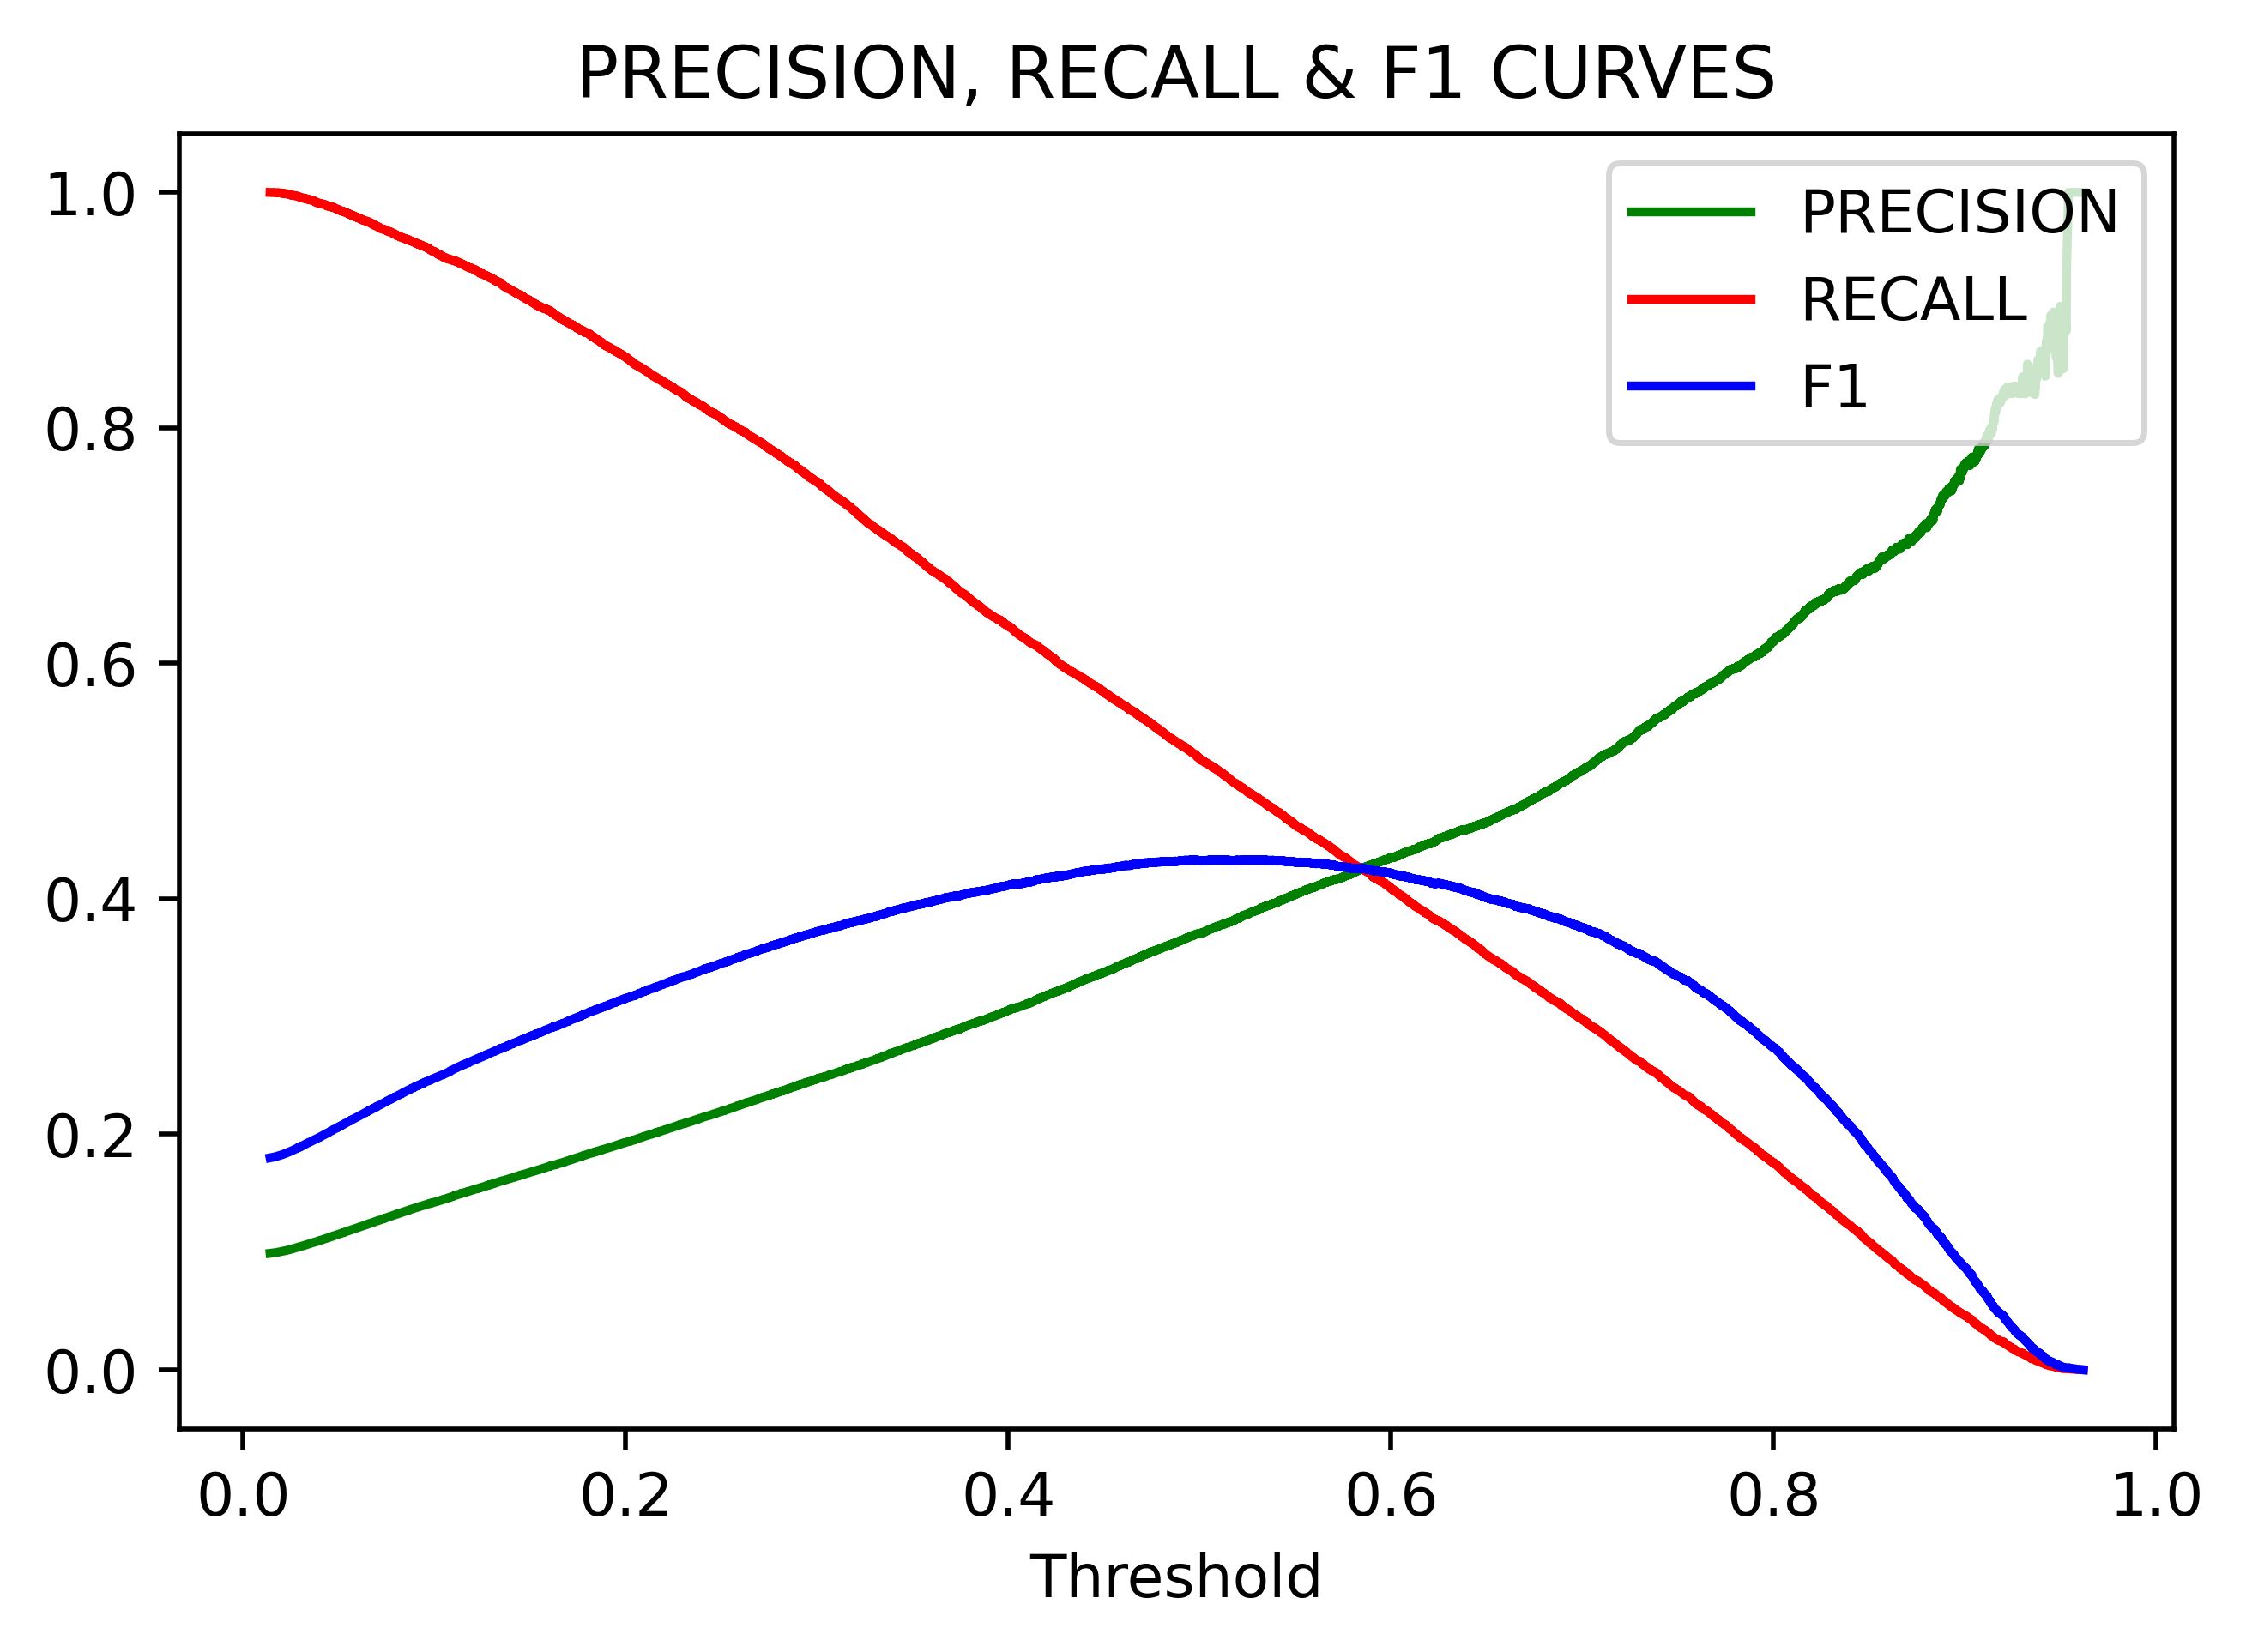

In [136]:
Curve_Precision, Curve_Recall, Curve_Threshold = precision_recall_curve(y_Test, Model_Gradient_Boosting.predict_proba(X_Test)[:,1] )
f1_curve = 2/(1/Curve_Recall + 1/Curve_Precision)

plt.figure(dpi=500)
plt.plot(Curve_Threshold, Curve_Precision[1:],label='PRECISION', color = 'g')
plt.plot(Curve_Threshold, Curve_Recall[1:], label='RECALL',color = 'r')
plt.plot(Curve_Threshold, f1_curve[1:], label='F1',color = 'b')
plt.legend(loc='upper right')
plt.xlabel('Threshold');
plt.title('PRECISION, RECALL & F1 CURVES');

In [179]:
logistic_regression_grocery = LogisticRegression(class_weight={1:3,0:1})
logistic_regression_grocery.fit(X_Train, y_Train)

C:\Users\LENOVO\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 1, 1: 3})

In [180]:
f1_score(y_Test,logistic_regression_grocery.predict(X_Test))

0.36856230031948883

In [181]:
logistic_regression_grocery_values=[]
rf_values=[]
gb_values=[]

In [182]:
logistic_regression_grocery_values.append(precision_score(y_Test,logistic_regression_grocery.predict(X_Test)))
logistic_regression_grocery_values.append(recall_score(y_Test,logistic_regression_grocery.predict(X_Test)))
logistic_regression_grocery_values.append(f1_score(y_Test,logistic_regression_grocery.predict(X_Test)))

rf_values.append(precision_score(y_Test,Model_random_forest.predict(X_Test)))
rf_values.append(recall_score(y_Test,Model_random_forest.predict(X_Test)))
rf_values.append(f1_score(y_Test,Model_random_forest.predict(X_Test)))

gb_values.append(precision_score(y_Test,Model_Gradient_Boosting.predict(X_Test)))
gb_values.append(recall_score(y_Test,Model_Gradient_Boosting.predict(X_Test)))
gb_values.append(f1_score(y_Test,Model_Gradient_Boosting.predict(X_Test)))

In [183]:
logistic_regression_grocery_values

[0.4017832265254946, 0.3404154863078376, 0.36856230031948883]

In [184]:
rf_values

[0.36202416793830167, 0.5180594900849859, 0.426209608895147]

In [185]:
gb_values

[0.3705295084038923, 0.5191218130311614, 0.4324164884595531]

In [186]:
import matplotlib.lines as mlines
import matplotlib.style as style
style.available

style.use('seaborn-whitegrid')

In [187]:
Graph_daataframe = pd.DataFrame([logistic_regression_grocery_values,rf_values,gb_values])

In [188]:
Graph_daataframe.columns = ['Precision','Recall','F1']

In [189]:
Graph_daataframe = Graph_daataframe.rename({2: 'Logistic Regression', 1: 'Random Forest', 0:'Gradient Boosting'})

In [190]:
Graph_daataframe

,Precision,Recall,F1
Gradient Boosting,0.401783,0.340415,0.368562
Random Forest,0.362024,0.518059,0.426210
Logistic Regression,0.370530,0.519122,0.432416


In [191]:
Bars_A = logistic_regression_grocery_values
Bars_B = rf_values
Bars_C = gb_values

In [192]:
barWidth = 0.1

In [193]:
r1 = np.arange(len(Bars_B))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

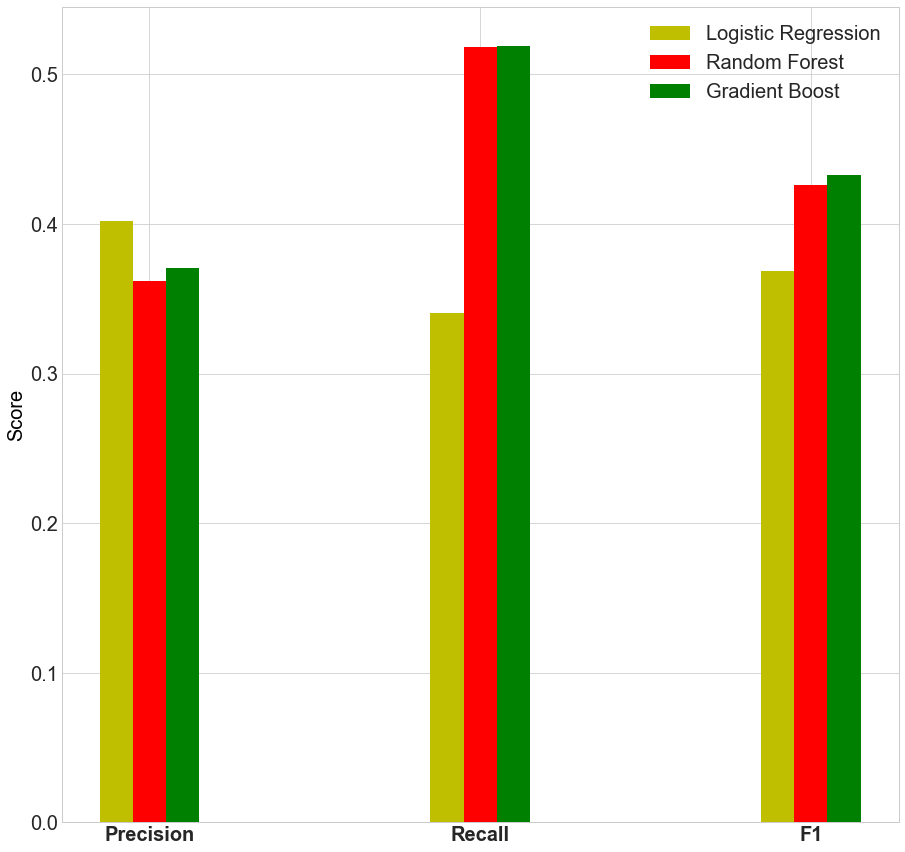

In [194]:
plt.figure(figsize=[15,15])

plt.bar(r1, Bars_A, width=barWidth, label='Logistic Regression', color ='y')
plt.bar(r2, Bars_B, width=barWidth, label='Random Forest',color ='r')
plt.bar(r3, Bars_C, width=barWidth, label='Gradient Boost',color ='g')

plt.xticks([r + barWidth for r in range(len(Bars_B))], ['Precision', 'Recall', 'F1'], 
           fontsize = 20,weight='bold')
plt.yticks(fontsize = 20)
plt.ylabel('Score', fontsize=20, color='black')
plt.legend(shadow = False,loc = 1, fontsize = 20)

plt.savefig("SUB_Models.png", bbox_inches='tight')